# **Recommender System**
#### Title: **Point-of-Interest (POI) Recommender**

##### Author: **`Bilal KACEL`**
##### Version: 1.0.0

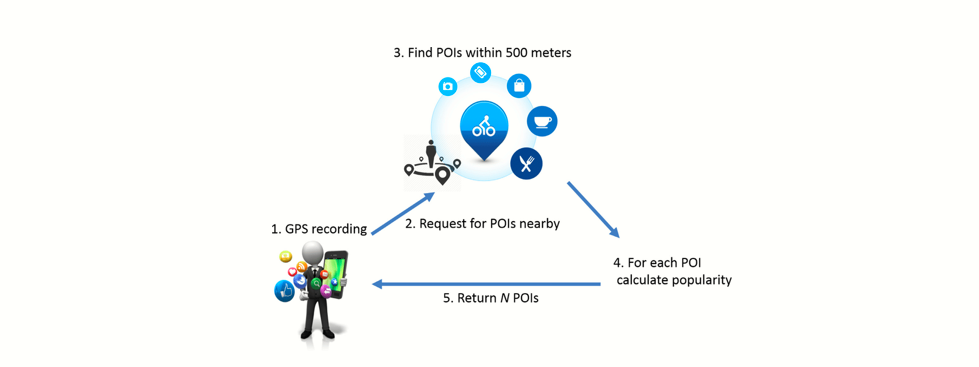

# **`ReadMe` - Conseils d'exécution**:
  Voici un petit récapitulatif du présent Notebook pour connaître sa structure globale et son contenu.

  - Les parties **2)**, **3)** et **4)** représentent le développement de fonctions élémentaires nécessaires pour réaliser ce qui est demandé pas-à-pas, fonction par fonction

  - Les parties **2)**, **3)** et **4)** ont été encapsulées dans des classes afin de simplifier la maintenance et l'utilisation

  - Si vous souhaitez tester les classes dans leur ensemble, il suffit de sauter à la partie **5.2)** et d'exécuter les parties suivantes:
    + **5.2.1)**, **5.2.2)**, **5.2.3)** et **5.2.4)**
    + Puis passer aux parties relatives au modèle **`GSLR`** en exécutant les parties: **5.3)** et **5.4)**

  - L'important est que vous sachiez que les classes écrites dans la partie **5.2)** implémentent davantage de contrôle sur les données

  - Dans la partie **5.2.2)** concerne l'implémentation de la préparation de données. Dedans, il y a un bout de code permettant de réduire le périmètre des données relativement aux localisations et ne garder que les positions se trouvant dans un rectangle de coordonnées délimités par un point Nord-Ouest et un autre point Sud-Est (Longitudes et latitudes)

# **Sommaire**

* **0)** **Manage DataFrames and Memory**

* **1)** **Introduction et instructions**

* **2)** **Chargement et traitement des données**
  - **2.0)** Connexion à **`Colab`** et import des dépendances...
  - **2.1)** Chargement des données
  - **2.2)** Retirer les utilisateurs avec un nombre de visites < 5
  - **2.3)** **`df_user_friends`**: Liste d'amis de chaque utilisateur
  - **2.4)** **`df_user_POI`**: Liste des POIs de chaque utilisateur
  - **2.5)** **`df_frequencies`**: Matrice des fréquences (utilisateur, POI)
  - **2.6)** Normalisation des fréquences [0, 10]
  - **2.7)** **`Surprise`**: Chargement du dataframe via Surprise
  - **2.8)** Split en Train et Test

* **3)** **Influence géographique**
  - **3.1)** **`distance()`**: Distance entre chaque paire de POI visités
  - **3.2)** **`density()`**: Densité d'une distance
  - **3.4)** **`geo_proba()`**: Probabilité finale qu'un Utilisateur visite un POI

* **4)** **Influence sociale**
  - **4.1)** **`social_similarity()`**: Similarité sociale
  - **4.2)** **`preference()`**: Préférence (Filtrage Collaboratif)
  - **4.3)** **`social_proba()`**: Prédiction

* **5)** **Génération et Evaluation des recommandations**
  - **5.1)** **`relevance_scores()`**: Scores de pertinence

  - **5.2)** Classes **`Data_Prep`**, **`Geo_influence`** et **`Social_influence`** (*Relevance_Scores* optionnelle)
    + *5.2.1) Connexion à **`Colab`** et import des packages*
    + *5.2.2) Classe `Data_Prep`*
    + *5.2.3) Classe `Geo_influence`*
    + *5.2.4) Classe `Social_influence`*
    + *5.2.5) Classe `Relevance_Scores` (NB: non-utilisée dans la classe `GSLR`)*
    + *5.2.6) Test des classes (Geo, Social and Scores)*

  - **5.3)** Classe **`GSLR`**: Implémentation d'un algorithme de recommandation

  - **5.4)** **`GSLR`**: Génération de recommandations et évaluation
    + *5.4.1) Cross-Validation, Génération des recommandation et calcul de la RMSE*
    + *5.4.2) Calcul de la `Precision@N` et le `Recall@N`*

  - **5.5)** Comparaison du modèle **`GSLR`** avec ceux de Surprise


# 0) **Manage DataFrames and Memory**

In [ ]:
!free -h
!nvidia-smi -L
!lscpu |grep 'Model name'
!lscpu | grep 'Core(s) per socket:'
!lscpu | grep 'Thread(s) per core'
!nvidia-smi
!nvcc --version

              total        used        free      shared  buff/cache   available
Mem:            12G        526M         11G        956K        623M         11G
Swap:            0B          0B          0B
GPU 0: Tesla T4 (UUID: GPU-6c105a19-36e5-d49d-dad5-fa8f9833b5a1)
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Core(s) per socket:  1
Thread(s) per core:  2
Sun Oct 25 15:39:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 0000000

In [ ]:
import sys

def sizeof_fmt(num, suffix='B'):
    """Function to get Memory Size of Notebook variables"""

    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)


for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

In [ ]:
#del df_user_friends_count
#del df_user_POI_count
#del df_frequencies_detailed
#del df_frequencies_visits
#del test
#del user_train
#del df_user_friends_count

#del df_checkins
#del df_friendship
#del df_user_info
#del df_test

# 1) **Introduction et instructions**

L’objectif ici est d’implémenter un algorithme de recommandation de points d’intérêt en se basant sur les données publiées sur les réseaux sociaux. Ces données couvrent en particulier les localisations des visites des utilisateurs ainsi que leurs relations sociales (ou “amis”), et peuvent être utilisées pour modéliser les préférences des utilisateurs et générer les recommandations.
Ce document décrit les différentes étapes pour l’implémentation de l’approche [**`iGSLR`**](https://drive.google.com/file/d/1DBq98KRWGRQyAJ0TqBqBKETGT90cyLwh/view?usp=sharing) qui se base sur du filtrage collaboratif et sur l’exploitation des influences géographiques et sociales. L’implémentation du modèle peut se faire à l’aide de la libraire [**`Surprise`**](http://surpriselib.com/).

- **Objectif:** implémenter un algorithme de Points d'intérêt basé sur les données de Réseaux Sociaux

- **Données**: elles couvrent:
    + Localisation des visites des utilisateurs
    + Relations sociales ("amis")
    
- **Utilité de ces données**: 
    + Ex: modéliser les préférences des utilisateurs et générer les recommandations

- **Approche à implémenter**: 
    + *`iGSLR`* (*Personalized Geo-Social Location Recommendation*)
    + L'approche est basée sur du *`Filtrage Collaboratif`* et sur l'*`Exploitation des influences`* géographiques et sociales

- **Librairie**: le modèle peut se faire via le framework ***`Surprise`***

# 2) **Chargement et traitement des données**

- **Compréhension des données:**
    + Ce sont des informations provenant du réseau social ***Gowalla***
    + Informations sur:
        - les profils des utilisateurs
        - leurs relations sociales
        - les localisations de leurs visites (POI: Points-of-Interest)
    + Volume: 
        - 36 001 969 visites
        - 407 533 utilisateurs
        - 2 724 891 POIs

- **Etapes de chargement et de traitement**:
  1.   Extraction du jeu de données + chargement dans un *dataframe* de *pandas*

  2.   Retirer les utilisateurs ayant effectué moins de 5 visites

  3.   A chaque utilisateur, associer sa liste d'amis => résultat dans un *dataframe*: ***`df_user_friends`***
  
  4.   A chaque utilisateur, associer sa liste de POI visités => résultat dans un *dataframe*: ***`df_user_POI`***

  5.   Pour chaque paire (utilisateur, POI), calculer la fréquence => résultat dans un *dataframe*: ***`df_frequencies`***

  6.   Mettre à jour les fréquences de *df_frequencies* pour les ramener à un intervalle [0, 10] via la formule:
  $x  -> 10 * tanH[10 * (x - fmin)/(fmax - fmin)]$
      - $fmin$ ($fmax$): nombre minimal (maximal) de fréquences de visites d'un POI quelconque dans le jeu de données

  7.   Charger *df_frequencies* dans le frame *`Surprise`* avec la fonction *`load_from_df()`*

  8.   Utiliser la fonction *`train_test_split()`* pour diviser *`df_frequencies`* en Train (75%) et Test (25%) sets. **Attention**: *`df_user_POI`* doit être créée à partir de l'ensemble de Train, afin d'éviter d'utiliser des données de l'ensemble de Test dans le phrase d'entraînement

## 2.0) **Connexion à Colab et import des dépendances...**

In [ ]:
# Accessing Files on Google Drive
from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install surprise

from tqdm import tqdm
import numpy as np
import math
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import cross_validate, KFold, train_test_split

from geopy.distance import geodesic, great_circle
import random

from surprise import AlgoBase
from surprise import PredictionImpossible
from collections import defaultdict

my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

## 2.1) **Chargement des données**

* Extraction du jeu de données + chargement dans un *dataframe* de *pandas*

In [ ]:
main_folder_path = "/content/gdrive/My Drive/Colab Notebooks/Recommendation System/data/POI/"

USER_INFO_DATA_FILE = main_folder_path + 'gowalla_userinfo.csv'
LOCATIONS_DATA_FILE = main_folder_path + 'gowalla_locations.csv'
FRIENDSHIP_DATA_FILE = main_folder_path + 'gowalla_friendship.csv'
CHECKINS_DATA_FILE = main_folder_path + 'gowalla_checkins.csv'

In [ ]:
df_user_info = pd.read_csv(USER_INFO_DATA_FILE) # informations utilisateurs:  id;friends_count;checkin_num
df_locations = pd.read_csv(LOCATIONS_DATA_FILE) # localisations:  id;lng;lat;checkins_count;users_count
df_friendship = pd.read_csv(FRIENDSHIP_DATA_FILE) # relations sociales entre utilisateurs:  userid1;userid2
df_checkins = pd.read_csv(CHECKINS_DATA_FILE) # visites:  userid;placeid

In [ ]:
df_user_info.head()

,id,friends_count,checkin_num
0,1,372,1766
1,2,775,2892
2,3,100,3021
3,4,179,1325
4,5,525,3215


In [ ]:
df_locations.head()

,id,lng,lat,checkins_count,users_count
0,8904,-94.607499,39.052318,114,21
1,8932,-97.254356,32.927662,67,48
2,8936,-94.591995,39.053318,75,46
3,8938,-94.590311,39.052824,438,94
4,8947,-122.029631,37.331880,3100,1186


In [ ]:
df_friendship.head()

,userid1,userid2
0,1,63488
1,1,2
2,1,3
3,1,4
4,1,5


In [ ]:
df_checkins.head()

,userid,placeid
0,1338,482954
1,1338,580963
2,1338,365256
3,1338,89504
4,1338,1267135


## 2.2) **Retirer les utilisateurs avec un nombre de visites < 5**

* Retirer les utilisateurs ayant effectué moins de 5 visites

In [ ]:
print("Number of Users initially:", df_user_info.shape[0])

df_user_info = df_user_info[ df_user_info["checkin_num"] >= 5 ] # Garder les utilisateurs avec +5 visites

# >>> df_user_info_more_5_visits = df_user_info[ df_user_info["checkin_num"] >= 5 ] # Garder les utilisateurs avec +5 visites
#df_user_info_more_5_visits = df_user_info[ (df_user_info["checkin_num"] <= 5) & (df_user_info["checkin_num"] >=2) ][:10] # Garder les utilisateurs avec +5 visites

print("Users with +5 check-ins:", df_user_info.shape[0])
#print("\t Ratio % Users with +5 check-ins:", df_user_info_more_5_visits.shape[0]/df_user_info.shape[0])

Number of Users initially: 407533
Users with +5 check-ins: 243294


## 2.3) **`df_user_friends`: Liste d'amis de chaque utilisateur**

* A chaque utilisateur, associer sa liste d'amis => résultat dans un *dataframe*: ***`df_user_friends`***

In [ ]:
# df_user_friends: la liste d'amis de chaque utilisateurs
# >>> df_user_friends = df_user_info_more_5_visits.join(df_friendship.set_index('userid1'), on="id").groupby('id')['userid2'].apply(lambda x: list(np.unique(x)) ).reset_index(name='friends_list')

df_user_friends = df_user_info.join(df_friendship.set_index('userid1'), on="id").groupby('id')['userid2'].apply(lambda x: list(np.unique(x)) ).reset_index(name='friends_list')
df_user_friends.head()

,id,friends_list
0,1,"[2, 3, 4, 5, 6, 7, 12, 18, 24, 25, 26, 28, 29,..."
1,2,"[1, 3, 4, 5, 6, 7, 11, 12, 18, 25, 29, 33, 40,..."
2,3,"[1, 2, 4, 5, 6, 7, 12, 18, 29, 33, 40, 44, 56,..."
3,4,"[1, 2, 3, 5, 6, 7, 12, 18, 24, 25, 29, 33, 43,..."
4,5,"[1, 2, 3, 4, 6, 7, 11, 12, 18, 24, 25, 29, 33,..."


In [ ]:
print("df_user_friends rows number:", df_user_friends.shape[0])

df_user_friends rows number: 243294


In [ ]:
# Export sample into a file

df_user_friends_count = df_user_friends.copy()

df_user_friends_count["friends_count"] = df_user_friends_count["friends_list"].apply(lambda x: len(x))

df_user_friends_count.head()


#df_user_friends_count[:3].to_csv("/content/gdrive/My Drive/Colab Notebooks/Recommendation System/Export_data/" + 'df_user_friends_count.csv', index = False, header=True)

,id,friends_list,friends_count
0,1,"[2, 3, 4, 5, 6, 7, 12, 18, 24, 25, 26, 28, 29,...",372
1,2,"[1, 3, 4, 5, 6, 7, 11, 12, 18, 25, 29, 33, 40,...",775
2,3,"[1, 2, 4, 5, 6, 7, 12, 18, 29, 33, 40, 44, 56,...",100
3,4,"[1, 2, 3, 5, 6, 7, 12, 18, 24, 25, 29, 33, 43,...",179
4,5,"[1, 2, 3, 4, 6, 7, 11, 12, 18, 24, 25, 29, 33,...",525


In [ ]:
df_user_friends_count.sort_values(by='friends_count', ascending=True).head(100000)

,id,friends_list,friends_count
243293,2688969,[2679767],1
31942,87672,[137763],1
138173,1569124,[171176],1
138155,1568020,[2518667],1
138153,1567952,[212345],1
...,...,...,...
218376,2393693,"[29203, 38141, 251815, 346705]",4
222092,2437535,"[23505, 773718, 1577124, 2298687]",4
70496,215528,"[260906, 272244, 2589889, 2661162]",4
153529,2090015,"[206865, 237347, 2090043, 2095162]",4


## 2.4) **`df_user_POI`: Liste des POIs de chaque utilisateur**

* A chaque utilisateur, associer sa liste de POI visités => résultat dans un *dataframe*: ***`df_user_POI`***

In [ ]:
# df_user_POI: liste des POI de chaque utilisateur
df_user_POI = df_user_friends.join(df_checkins.set_index('userid'), on="id").groupby('id')['placeid'].apply(lambda x: list(np.unique(x)) ).reset_index(name='poi_list')
df_user_POI.head()

,id,poi_list
0,1,"[8904, 8938, 8947, 8956, 8957, 8961, 8964, 896..."
1,2,"[8947, 8956, 8957, 8982, 8988, 8989, 8997, 899..."
2,3,"[8932, 8954, 8956, 8957, 8961, 8982, 8988, 899..."
3,4,"[8947, 8956, 8957, 8982, 8988, 8997, 8998, 905..."
4,5,"[8947, 8956, 8957, 8961, 8982, 8988, 8989, 899..."


In [ ]:
print("df_user_POI rows number:", df_user_POI.shape[0])

df_user_POI rows number: 243294


In [ ]:
# Export sample into a file

df_user_POI_count = df_user_POI.copy()

df_user_POI_count["poi_count"] = df_user_POI_count["poi_list"].apply(lambda x: len(x))

#df_user_POI[ df_user_POI["id"] == 2393693].to_csv("/content/gdrive/My Drive/Colab Notebooks/Recommendation System/Export_data/" + 'df_user_POI.csv', index = False, header=True)

df_user_POI_count[ df_user_POI_count["id"] == 2393693]
#df_user_POI_count[ df_user_POI_count["id"] == 229]

,id,poi_list,poi_count
218376,2393693,"[9356, 9507, 11507, 12207, 12965, 14644, 14662...",77


## 2.5) **`df_frequencies`: Matrice des fréquences (utilisateur, POI)**
* Pour chaque paire (utilisateur, POI), calculer la fréquence => résultat dans un *dataframe*: ***`df_frequencies`***

In [ ]:
# Etape 1: df_frequencies_visits contient le nombre de visites d'un POI par un utilisateur
df_frequencies_visits = df_checkins.groupby(['userid', 'placeid']).size().reset_index(name='nb_visits')
df_frequencies_visits.head()

,userid,placeid,nb_visits
0,1,8904,72
1,1,8938,11
2,1,8947,12
3,1,8956,1
4,1,8957,1


In [ ]:
# df_frequencies_detailed: Fréquence de visite d'un utilisateur pour chaque POI

df_frequencies_detailed = df_frequencies_visits.join(df_user_info.set_index('id'), on='userid')

df_frequencies_detailed['frequency'] = df_frequencies_detailed['nb_visits']/df_frequencies_detailed['checkin_num']

df_frequencies_detailed.head()

,userid,placeid,nb_visits,friends_count,checkin_num,frequency
0,1,8904,72,372.0,1766.0,0.040770
1,1,8938,11,372.0,1766.0,0.006229
2,1,8947,12,372.0,1766.0,0.006795
3,1,8956,1,372.0,1766.0,0.000566
4,1,8957,1,372.0,1766.0,0.000566


In [ ]:
print("df_frequencies_detailed rows number:", df_frequencies_detailed.shape[0])

df_frequencies_detailed rows number: 19502140


In [ ]:
df_frequencies_detailed[ df_frequencies_detailed["userid"] == 2393693 ]

,userid,placeid,nb_visits,friends_count,checkin_num,frequency
18822650,2393693,9356,2,4.0,116.0,0.017241
18822651,2393693,9507,1,4.0,116.0,0.008621
18822652,2393693,11507,1,4.0,116.0,0.008621
18822653,2393693,12207,4,4.0,116.0,0.034483
18822654,2393693,12965,1,4.0,116.0,0.008621
...,...,...,...,...,...,...
18822722,2393693,6733784,2,4.0,116.0,0.017241
18822723,2393693,7004329,1,4.0,116.0,0.008621
18822724,2393693,7026527,2,4.0,116.0,0.017241
18822725,2393693,7087446,1,4.0,116.0,0.008621


In [ ]:
# Export sample into a file

df_frequencies_detailed[ df_frequencies_detailed["userid"] == 2393693 ].sort_values(by='frequency', ascending=False).to_csv("/content/gdrive/My Drive/Colab Notebooks/Recommendation System/Export_data/" + 'df_frequencies_detailed.csv', index = False, header=True)

df_frequencies_detailed[ df_frequencies_detailed["userid"] == 2393693 ].sort_values(by='frequency', ascending=False).head()

,userid,placeid,nb_visits,friends_count,checkin_num,frequency
18822705,2393693,1319444,6,4.0,116.0,0.051724
18822680,2393693,194944,5,4.0,116.0,0.043103
18822696,2393693,917132,5,4.0,116.0,0.043103
18822702,2393693,1168002,4,4.0,116.0,0.034483
18822714,2393693,5443062,4,4.0,116.0,0.034483


## 2.6) **Normalisation des fréquences [0, 10]**
* Mettre à jour les fréquences de *df_frequencies* pour les ramener à un intervalle [0, 10] via la formule:
  + $x  -> 10 * tanH[10 * (x - fmin)/(fmax - fmin)]$
  + Sachant: $fmin$ ($fmax$): nombre minimal (maximal) de fréquences de visites d'un POI quelconque dans le jeu de données

In [ ]:
fmin = df_frequencies_detailed['frequency'].min()
fmax = df_frequencies_detailed['frequency'].max()

print("Min frequency (fmin):", fmin)
print("MAX frequency (fmax):", fmax)

etendu = fmax - fmin

df_frequencies_detailed['frequency'] = df_frequencies_detailed['frequency'].apply(lambda x: 10 * math.tanh(10 * (x - fmin)/(etendu) ) )


# TODO: use Numpy to normalize data instead a math.tanh function
test = 10 * np.tanh(10 * (df_frequencies_detailed['frequency'] - fmin)/(etendu) )

Min frequency (fmin): 2.1285200400161767e-05
MAX frequency (fmax): 1.0


In [ ]:
df_frequencies = df_frequencies_detailed[ ['userid', 'placeid', 'frequency'] ] # Il est semblable au format: [User, Item, Rating]
df_frequencies.head()

,userid,placeid,frequency
0,1,8904,3.863452
1,1,8938,0.619965
2,1,8947,0.676353
3,1,8956,0.054497
4,1,8957,0.054497


In [ ]:
# Export sample into a file

df_frequencies[ df_frequencies["userid"] == 2393693 ].sort_values(by='frequency', ascending=False).to_csv("/content/gdrive/My Drive/Colab Notebooks/Recommendation System/Export_data/" + 'df_frequencies.csv', index = False, header=True)

## 2.7) **`Surprise`: Chargement du dataframe via `Surprise`**
* Charger *df_frequencies* dans le frame *`Surprise`* avec la fonction *`load_from_df()`*

In [ ]:
# Reader de Surprise
reader = Reader(rating_scale=(0, 5)) # Nombre d'étoiles: [0, 5]

# Chargement de toutes les Fréquences à partir du DataFrame au format: [User, Item, Rating] equivalent to [User, POI, Frequency]
frequencies = Dataset.load_from_df(df_frequencies, reader)

## 2.8) **Split en Train et Test**
* Utiliser la fonction *`train_test_split()`* pour diviser *`df_frequencies`* en Train (75%) et Test (25%) sets. 
* **Attention**: *`df_user_POI`* doit être créée à partir de l'ensemble de Train, afin d'éviter d'utiliser des données de l'ensemble de Test dans le phrase d'entraînement

In [ ]:
# Split en Train et Test
train_data, test_data = train_test_split(frequencies, test_size=0.25)

In [ ]:
# Ici, il sera nécessaire de retirer du dataframe df_user_POI les utilisateurs n'existant pas dans le Train set créé dans le split
user_train = set() # Créer un set vide

# Récupérer la liste d'utilisateurs contenus dans le Train set
for user in df_user_POI['id']: # Parcourir la liste des utilisateurs contenus dans le dataframe complet
  if train_data.knows_user(user): # si l'utilisateur existe dans le Train set alors l'ajouter au set qui nous servira à filtrer le dataframe global
    user_train.add(user)

# Eliminer de df_user_POI les utilisateurs ne font pas partie du Train set (et qui feront donc partie du Test set)
train_df_user_POI = df_user_POI[ df_user_POI['id'].isin(user_train) ]

In [ ]:
print("df_user_friends={} \t df_user_POI={} \t df_frequencies={}".format(len(df_user_friends), len(df_user_POI), len(df_frequencies) ))

train_df_user_friends, train_df_user_POI, train_df_frequencies, test_df_user_friends, test_df_user_POI, test_df_frequencies = get_train_datasets(train_data, df_user_friends, df_user_POI, df_frequencies)

print("\n train_df_user_friends={} \n train_df_user_POI={} \n train_df_frequencies={} \n test_df_user_friends={} \n test_df_user_POI={} \n test_df_frequencies={}  ".format(len(train_df_user_friends), len(train_df_user_POI), len(train_df_frequencies), len(test_df_user_friends), len(test_df_user_POI), len(test_df_frequencies) ))

df_user_friends=243294 	 df_user_POI=243294 	 df_frequencies=19502140

 train_df_user_friends=93166 
 train_df_user_POI=93166 
 train_df_frequencies=10727194 
 test_df_user_friends=150128 
 test_df_user_POI=150128 
 test_df_frequencies=2712305  


# 3) **Influence géographique**

Le dataframe **`df_user_POI`** associe chaque utilisateur $u$ à la liste $L_u$ des POIs qu’il a visité.

## 3.1) **`distance()`: Distance entre chaque paire de POI visités**

Utiliser **`df_user_POI`**  pour calculer pour chaque utilisateur $u$ les distances $d_{ij}$ entre chaque paire
de POIs visités: 

$\forall$ $p_i, p_j$ $\in$ $L_u$ x $L_u$, 
$d_{ij}$ = $distance(p_i, p_j)$. On dénotera cette liste de distances
par $D_u$.

In [ ]:
print("Initial Users count: ", len(df_user_POI))
print("Train Users count: ", len(train_df_user_POI))

Initial Users count:  243294
Train Users count:  93159


In [ ]:
def get_list_poi_user(user):
  """Function to get the POIs list for a user"""

  poi_list = train_df_user_POI [ train_df_user_POI['id'] == user ]['poi_list'].item()
  return poi_list

In [ ]:
def distance(pi, pj):
  """Function to compute Geodesic distance (in Kilometers) between two POIs"""

  pi_info = df_locations[ df_locations['id']== pi]
  pj_info = df_locations[ df_locations['id']== pj]

  pi_coordinates = ( pi_info['lat'].item(), pi_info['lng'].item() ) # Get Pi coodinates
  pj_coordinates = ( pj_info['lat'].item(), pj_info['lng'].item() ) # Get Pj coodinates

  distance_computed = geodesic(pi_coordinates, pj_coordinates).km # Geodesic distance in Kilometers
  #distance_computed = great_circle(pi_coordinates, pj_coordinates).km # Geodesic distance in Kilometers

  return distance_computed


distance(8904, 8938)

1.4888550353951269

In [ ]:
def user_poi_distance(user):
  """Function to compute distance between all visited POIs of the User given in parameter"""

  distance_dict = {}

  #user_poi_list = train_df_user_POI[ train_df_user_POI['id']==user ]['poi_list'].values[0]
  user_poi_list = get_list_poi_user(user=user)

  for poi_i in user_poi_list:
    for poi_j in user_poi_list:
      
      # Condition to get only one instance of a distance between two POIs like (A, B) = (B, A)
      if poi_i != poi_j and (poi_i, poi_j) not in distance_dict and (poi_j, poi_i) not in distance_dict:

        distance_dict[(poi_i, poi_j)] = distance(poi_i, poi_j)

  distances_list = list(distance_dict.values())

  #return distance_dict
  return distances_list

**Test the function below**

In [ ]:
train_df_user_POI_distance = train_df_user_POI.copy()

train_df_user_POI_distance.head()

,id,poi_list
0,1,"[8904, 8938, 8947, 8956, 8957, 8961, 8964, 896..."
1,2,"[8947, 8956, 8957, 8982, 8988, 8989, 8997, 899..."
2,3,"[8932, 8954, 8956, 8957, 8961, 8982, 8988, 899..."
3,4,"[8947, 8956, 8957, 8982, 8988, 8997, 8998, 905..."
4,5,"[8947, 8956, 8957, 8961, 8982, 8988, 8989, 899..."


In [ ]:
train_df_user_POI_distance = train_df_user_POI_distance[ train_df_user_POI_distance["id"].isin([260002, 53, 551])]
#train_df_user_POI_distance = train_df_user_POI_distance[ train_df_user_POI_distance["id"].isin([551])]

train_df_user_POI_distance["distance"] = train_df_user_POI_distance["id"].apply(lambda x: user_poi_distance(x))

train_df_user_POI_distance

,id,poi_list,distance
30,53,"[17579, 286512, 290022, 644423, 1541920]","[22.436737986397, 44.615610321059926, 22.55346..."
307,551,"[10801, 315598, 1076617]","[1.1603400558521082, 0.24949135646280282, 0.94..."
82168,260002,"[167458, 742138, 1096244, 1098880]","[10.71895779513953, 2.3561394566630582, 0.5845..."


In [ ]:
# Export sample into a file

"""
train_df_user_POI_count = train_df_user_POI.copy()

train_df_user_POI_count["poi_count"] = train_df_user_POI_count["poi_list"].apply(lambda x: len(x))

#df_user_POI[ df_user_POI["id"] == 2393693].to_csv("/content/gdrive/My Drive/Colab Notebooks/Recommendation System/Export_data/" + 'df_user_POI.csv', index = False, header=True)

#train_df_user_POI_count[ train_df_user_POI_count["id"] == 2393693]

train_df_user_POI_count[ train_df_user_POI_count["poi_count"] == 3  ].sort_values(by='poi_count', ascending=True)
"""

'\ntrain_df_user_POI_count = train_df_user_POI.copy()\n\ntrain_df_user_POI_count["poi_count"] = train_df_user_POI_count["poi_list"].apply(lambda x: len(x))\n\n#df_user_POI[ df_user_POI["id"] == 2393693].to_csv("/content/gdrive/My Drive/Colab Notebooks/Recommendation System/Export_data/" + \'df_user_POI.csv\', index = False, header=True)\n\n#train_df_user_POI_count[ train_df_user_POI_count["id"] == 2393693]\n\ntrain_df_user_POI_count[ train_df_user_POI_count["poi_count"] == 3  ].sort_values(by=\'poi_count\', ascending=True)\n'

## 3.2) **`density()`: Densité d'une distance**

* Utiliser $D_u$ pour calculer la densité $f_u$ d'une distance quelconque comme suit: 

\begin{equation}
\hat{f}_u(d_{ij}) = \frac{1}{|D_u| h} \left ( \sum_{d'\in D_u} K(\frac{d_{ij} - d'}{h}) \right )
\end{equation}

* $K(.)$ est choisi comme étant la densité d'une fonction gaussienne:

\begin{equation}
\ K(x) = \frac{1}{\sqrt{2\pi}} e^-\frac{x^2}{2}
\end{equation}

* Le paramètre de lissage $h = 1,06\hat{\sigma} n^{-1/5}$ où:
  + $n$: est le nombre de POIs présents dans $L_u$
  + $\hat{\sigma}$: est l'écart-type de $D_u$

* Implémenter l'équation de densité $\hat{f}_u(d_{ij})$ dans une fonction **`density()`**

* La densité $\hat{f}_u$ est utilisée pour estimer la probabilité qu'un POI $p_i$ non visité par un utilisateur $u$ corresponde aux préférences géographiques de $u$ étant donné son historique de visite. Afin d'obtenir cette probabilité, on calcule la distance entre $p_i$ et chacun des POIs de la liste $L_u$ et on estime ensuite la probabilité de chacune de ces distances en passant par $\hat{f}_u$

In [ ]:
def gaussian_density(x):
  """Compute the Gaussian Density"""

  return ( 1 / np.sqrt(2 * np.pi) ) * np.exp(-x**2/2)

In [ ]:
def density(Lu, Du, d):
  """Function to compute the density between any distance"""

  #Lu = get_list_poi_user(user=user) # to get the POIs list for a user
  #Du = user_poi_distance(user=user) # Get distance between all visited POIs of the User given in parameter

  Du_length = len(Du) # Nb POIs pairs

  #distances_list = list(Du.values()) # Get list of all distances between the current User POIs

  std = np.std( Du ) # 'Du' standard deviation (distances)
  n = len(Lu) # Nb of POIs
  h = 1.06 * std * math.pow(n, -1/5) # Smoothing parameter: https://en.wikipedia.org/wiki/Kernel_density_estimation
  K = gaussian_density # Gaussian Density defined in a function just above

  density_computed = 1/(Du_length * h) * np.sum([ K((d - distance)/h) for distance in Du]) # Density formula
  
  return density_computed

**Test the function below**

In [ ]:
train_df_user_POI_distance

,id,poi_list,distance
30,53,"[17579, 286512, 290022, 644423, 1541920]","[22.436737986397, 44.615610321059926, 22.55346..."
307,551,"[10801, 315598, 1076617]","[1.1603400558521082, 0.24949135646280282, 0.94..."
82168,260002,"[167458, 742138, 1096244, 1098880]","[10.71895779513953, 2.3561394566630582, 0.5845..."


In [ ]:
train_df_user_POI_distance['density'] = train_df_user_POI_distance.apply(lambda x : density( Lu=get_list_poi_user(x['id']), Du=user_poi_distance(x['id']), d=5) , axis=1)

train_df_user_POI_distance

,id,poi_list,distance,density
30,53,"[17579, 286512, 290022, 644423, 1541920]","[22.436737986397, 44.615610321059926, 22.55346...",1.394249e-02
307,551,"[10801, 315598, 1076617]","[1.1603400558521082, 0.24949135646280282, 0.94...",1.887623e-30
82168,260002,"[167458, 742138, 1096244, 1098880]","[10.71895779513953, 2.3561394566630582, 0.5845...",4.987038e-02


## 3.4) **`geo_proba()`: Probabilité finale qu'un Utilisateur visite un POI**

* La probabilité finale qu'un utilisateur $u$ visite un POI $p_i$ est obtenue comme suit:

\begin{equation}
P(p_i|L_u) = \frac{1}{n} \left ( \sum_{j=1}^n \hat{f}_u(d_{ij}) \right )
\end{equation}

* $P(p_i|L_u)$: représente la probabilité que l'utilisateur $u$ visite le POI $p_i$ étant donné le critère géographique.

* Implémenter l'équation ci-dessus de $P(p_i|L_u)$ dans une fonction **`geo_proba()`** qui prend en entrée la liste $L_u$ et un POI et qui retourne la probabilité de visite de ce POI

In [ ]:
def geo_proba(user, new_poi):
  """Function to get the probability of a User to visit a POI (never visited)"""
  
  Lu = get_list_poi_user(user=user) # to get the POIs list for a user
  Du = user_poi_distance(user=user) # Get distance between all visited POIs of the User given in parameter
  n = len(Lu)  # Nb of POIs

  # We compute the distance between the New POI and all other POIs visited by the User.
  # Then, we cumulate the Densities which we divide by the number POIs visited
  proba = (1/n) * np.sum([ density(Lu, Du, distance(pi=visited_poi, pj=new_poi) ) for visited_poi in Lu ])

  return proba

**Test the function below**

In [ ]:
train_df_user_POI_distance['proba'] = train_df_user_POI_distance.apply(
    lambda x : geo_proba(user=x['id'], new_poi=315598),
    axis=1)

In [ ]:
train_df_user_POI_distance

,id,poi_list,distance,density,proba
30,53,"[17579, 286512, 290022, 644423, 1541920]","[22.436737986397, 44.615610321059926, 22.55346...",1.394249e-02,0.000000
307,551,"[10801, 315598, 1076617]","[1.1603400558521082, 0.24949135646280282, 0.94...",1.887623e-30,0.605389
82168,260002,"[167458, 742138, 1096244, 1098880]","[10.71895779513953, 2.3561394566630582, 0.5845...",4.987038e-02,0.000000


# 4) **Influence sociale**

* Le dataframe **`df_user_friends`** associe chaque utilisateur $u$ à ses amis $F(u)$

## 4.1) **`social_similarity()`: Similarité sociale**

* Pour chaque paire d'utilisateur $(u, v)$, on calcule leur *similarité sociale* en utilisant le coefficient de ***Jaccard***:

\begin{equation}
sim(u, v) = \frac{| F(u) \bigcap F(v) |}{| F(u) \bigcup F(v) |}
\end{equation}

* Implémenter ce coefficient dans la fonction **`social_similarity()`**

In [ ]:
def get_user_friends(user):
  """Get user friends list"""

  return df_user_friends[ df_user_friends['id'] == user ]['friends_list']
  #return df_user_friends[ df_user_friends['id'] == user ]['friends_list'].item()
  #return df_user_friends[ df_user_friends['id'] == user ]['friends_list'].tolist()

In [ ]:
def social_similarity(u, v):
  """Compute Jaccard similarity between two Users according to their respectives friends"""

  #u_friends = df_user_friends[ df_user_friends['id'] == u ]['friends_list'].item()
  #v_friends = df_user_friends[ df_user_friends['id'] == v ]['friends_list'].item()

  u_friends = get_user_friends(u).item()
  v_friends = get_user_friends(v).item()

  return len( np.intersect1d(u_friends, v_friends) ) / len( np.union1d(u_friends, v_friends) )



social_similarity(1, 3)

0.102803738317757

In [ ]:
# UserID=261 (friends_count=2, checkin_num=7)
# UserID=45 (friends_count=3, checkin_num=6)
# UserID=501 (friends_count=5, checkin_num=8)

## 4.2) **`preference()`: Préférence (Filtrage Collaboratif)**

* Ce coefficient de ***Jaccard*** peut être utilisé dans un modèle de *Filtrage Collaboratif* comme suit:

\begin{equation}
\hat{r}_{ui} = \frac{\sum_{v \in F(u)} r_{vi} . sim(u,v)}{\sum_{v \in F(u)}sim(u,v)}
\end{equation}

* $r_{ui}$: indique la fréquence de visite de $u$ dans $i$, extraite de **`df_frequencies`**

In [ ]:
def get_user_poi_frequency(user, poi):
  """Get user POI frequency"""

  return df_frequencies[ (df_frequencies['userid'] == user) & (df_frequencies['placeid'] == poi) ]['frequency']

In [ ]:
def preference(user, new_poi):
  """Estimate a user's preference for a POI never visited"""

  user_friends_list = get_user_friends(user).item() # Get user friends list

  numerator = []
  denominator = []

  # Browse User friends in order to:
  #   - Get friend friends list
  #   - Compute Similarity for between User and his friends
  #   - Get friend POI frequency

  friend_size = 0
  friends_count = len(user_friends_list)

  for friend in user_friends_list:

    friend_friends_list = get_user_friends(friend) # Get friend friends list
    friend_poi_freq = get_user_poi_frequency(friend, new_poi) # Get friend POI frequency

    
    friend_size += 1
    #print("Friend {}/{}".format(friend_size, friends_count))

    #print("Friend {}/{} ".format(friend_size, friends_count), "\t User:", user, "\t friend:", friend, "\t POI:", poi, )

    """
    if (not friend_friends_list.empty): 
      print("\t Amis des Amis: ", friend_friends_list.item())
    else: 
      print("\t Amis des Amis: ", "Vide")

    if (not friend_poi_freq.empty): 
      print("\t Friend POI freq:", friend_poi_freq.item())
    else: 
      print("\t Friend POI freq:", "Vide")
    """



    if not friend_friends_list.empty and not friend_poi_freq.empty:
      #print("\t Similarité:", social_similarity(user, friend))
      #print("\t %%% Fréquence:", get_user_poi_frequency(friend, poi).item())

      similarity = social_similarity(user, friend)
      
      numerator.append(friend_poi_freq.item() * similarity)
      denominator.append(similarity)


    #print("\n")

  #print("np.sum(numerator): ", np.sum(numerator))
  #print("np.sum(denominator): ", np.sum(denominator))

  # Compute the preference
  
  if np.sum(denominator) is np.nan or np.sum(denominator) == 0.0:
    preference = 0.0

  else:
    preference = np.sum(numerator) / np.sum(denominator)
  
  #print("\t *Preference*:", preference)
  #print('\n')

  return preference

In [ ]:
preference(user=3, new_poi=8904)

1.0683779005656355

## 4.3) **`social_proba()`: Prédiction**

* La prédiction $\hat{r}_{ui}$ peut être transformée en proabilité comme suit:

\begin{equation}
\hat{P}_{ui} = \frac{\hat{r}_{ui}}{\max_{p_j \in L \backslash L_U} \hat{r}_{uj}  }
\end{equation}

* $L$: est la liste de POIs

In [ ]:
def social_proba(user, new_poi):
  """Compute the Social Probability for a User related to a new POI"""
  
  #user = 187
  #new_poi = 25572 # New POI

  preference_new_poi = preference(user, new_poi)

  #user_poi_list = df_user_POI[ df_user_POI[ "id" ] == user]['poi_list'].item() # Target User
  user_poi_list = get_list_poi_user(user=user) # Target User

  preferences = [preference(user=user, new_poi=poi) for poi in user_poi_list]
  max_pref = np.max(preferences)

  """
  print('\n')
  print('===> preference_new_poi: ', preference_new_poi)
  print('===> preferences: ', preferences)
  print('===> MAX: ', max_pref)
  """

  proba = preference_new_poi / max_pref
  #print('===> Proba %: ', proba)

  return proba

**Test the function below**

In [ ]:
social_proba(user=187, new_poi=25572)

0.46872167038790885

In [ ]:
train_df_user_POI_187 = train_df_user_POI[ (train_df_user_POI['id'] == 187)].copy()

train_df_user_POI_187['social_proba_25572'] = train_df_user_POI_187[ (train_df_user_POI_187['id'] == 187)].apply(lambda x : social_proba(x['id'], 25572), axis=1 )

In [ ]:
train_df_user_POI_187

,id,poi_list,social_proba_25572
127,187,"[8989, 10643, 13427, 17099, 25008, 25572, 1046...",0.468722


# 5) **Génération et Evaluation des recommandations**

## 5.1) **`relevance_scores()`: Scores de pertinence**

* Afin de générer les recommandations, on calcule les scores de pertinence $\hat{s}_{ui}$ pour un utilisateur $u$ et un POI $i$ comme suit:

\begin{equation}
\hat{s}_{ui} = \frac{\hat{P}_{ui} + P(p_i|L_u)}{2} = \frac{geo proba() + social proba()}{2} = \frac{Influence Géographique +  Influence Sociale}{2}
\end{equation}

In [ ]:
def get_relevance_score(user, new_poi):
  """Compute Relevance Score for a User and a POI"""
    
  #geo_probability = geo_proba(new_poi, Lu=get_list_poi_user(user=user), Du=user_poi_distance(user_id=user)) # Get Geography influence
  #social_probability = social_proba(user, new_poi) # Get Social influence

  geo_probability = Geo_influence(df_locations, df_user_POI).geo_proba(user=user, new_poi=new_poi) # Get Geography influence
  social_probability = Social_influence(df_user_friends, df_user_POI, df_frequencies).social_proba(user=user, new_poi=new_poi) # Get Social influence

  score = (geo_probability + social_probability)/2      # Compute Relevance Score

  """
  print("geo_probability: ", geo_probability)
  print("social_probability: ", social_probability)
  """

  return (new_poi, score) # Get the tuple (POI, Score)

In [ ]:
def relevance_scores(user, restricted=None):
  """Function to compute relevance scores on all POIs never visited by a User and sort the result by descending order"""


  all_poi = df_locations['id'] # Get all existing POIs
  poi_never_visited = list( set(all_poi) - set(get_list_poi_user(user=user)) ) # Get all POIs never visited by the User

  if restricted is not None:
    np.random.shuffle(poi_never_visited) # Shuffle the POI list
    poi_never_visited = poi_never_visited[:restricted]

  
  print("poi_never_visited: ", poi_never_visited)

  all_scores = []

  nb_pois_to_visit = len(poi_never_visited) # nb of all POIs to propose
  poi_count = 0

  for new_poi in poi_never_visited:
    poi_and_score = get_relevance_score(user, new_poi) # Get relevance score on POI and a User
    
    poi_count += 1
    print("POI {}/{}".format(poi_count, nb_pois_to_visit), '\t POI-Score=', poi_and_score)

    all_scores.append( poi_and_score )

  
  #return all_scores
  return sorted(all_scores, key=lambda x: x[1], reverse=True)

**Test the function below**

In [ ]:
train_df_user_POI_187.head()

NameError: ignored

In [ ]:
train_df_user_POI_187['relevance_scores'] = train_df_user_POI_187.apply(lambda x : relevance_scores(user=x['id']), axis=1 )

train_df_user_POI_187

In [ ]:
train_df_user_POI_187['relevance_scores'].item()[:10] # Top-10 of POIs

## 5.2) **Classes `Data_Prep`, `Geo_influence` et `Social_influence` (`Relevance_Scores` optionnelle)**

### 5.2.1) **Connexion à `Colab` et import des packages**

In [ ]:
# Accessing Files on Google Drive
from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
drive.mount('/content/gdrive')

In [ ]:
!pip install surprise

from tqdm import tqdm
import numpy as np
import math
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import cross_validate, KFold, train_test_split

from geopy.distance import geodesic, great_circle
import random

from surprise import AlgoBase
from surprise import PredictionImpossible
from collections import defaultdict

my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

### 5.2.2) **Classe `Data_Prep`**

In [ ]:
class Data_Prep():
  """Common base class for DataFrames preparation"""


  # Default constructor
  def __init__(self, main_folder_path, fraction=1.0):
    print("Start Data Preparation ...")

    #fraction = 0.005
    #fraction = 0.80

    self.main_folder_path = main_folder_path
    USER_INFO_DATA_FILE = self.main_folder_path + 'gowalla_userinfo.csv'
    LOCATIONS_DATA_FILE = self.main_folder_path + 'gowalla_locations.csv'
    FRIENDSHIP_DATA_FILE = self.main_folder_path + 'gowalla_friendship.csv'
    CHECKINS_DATA_FILE = self.main_folder_path + 'gowalla_checkins.csv'

    print("Data Loading ...")
    self.df_user_info = pd.read_csv(USER_INFO_DATA_FILE)  # informations utilisateurs:  id;friends_count;checkin_num
    self.df_locations = pd.read_csv(LOCATIONS_DATA_FILE)  # localisations:  id;lng;lat;checkins_count;users_count
    self.df_friendship = pd.read_csv(FRIENDSHIP_DATA_FILE)  # relations sociales entre utilisateurs:  userid1;userid2
    self.df_checkins = pd.read_csv(CHECKINS_DATA_FILE)  # visites:  userid;placeid

    """
    print("\n Initial")
    print("\t len(self.df_user_info)= ", len(self.df_user_info))
    print("\t len(self.df_locations)= ", len(self.df_locations))
    print("\t len(self.df_friendship)= ", len(self.df_friendship))
    print("\t len(self.df_checkins)= ", len(self.df_checkins))
    """


    # Reduce locations according to a rectangle coordinates
    """
    # France coordinates (like a rectangle)
    top_left_longitude = -4.76
    top_left_latitude = 50.85

    bottom_right_longitude = 9.66
    bottom_right_latitude = 41.46


    # Kansas (USA) coordinates (like a rectangle)
    #top_left_longitude = -101.94
    #top_left_latitude = 39.84
    #bottom_right_longitude = -94.98
    #bottom_right_latitude = 37.22

    self.df_locations = self.df_locations[ 
        (self.df_locations['lng'] >= top_left_longitude ) & (self.df_locations['lng'] <= bottom_right_longitude ) &
        (self.df_locations['lat'] <= top_left_latitude ) & (self.df_locations['lat'] >= bottom_right_latitude )
    ]

    # Reduce checkins
    self.df_checkins = self.df_checkins[ self.df_checkins['placeid'].isin(self.df_locations['id']) ]
    """



    # Remove users with less than 5 visits
    print("Remove users with less than 5 visits ...")
    self.df_user_info = self.df_user_info[ self.df_user_info["checkin_num"] >= 5 ] # Garder les utilisateurs avec +5 visites
    #self.df_user_info = self.df_user_info[ (self.df_user_info["checkin_num"] <= 20) & (self.df_user_info["checkin_num"] >= 10) ].sample(n=10) # In order to test on a small set of users, we revsered the condition

    """
    print("\n After reducing users")
    print("\t len(self.df_user_info)= ", len(self.df_user_info))
    """

    # Get the user friends in a list
    print("Get the user friends in a list ...")
    self.df_user_friends = self.df_user_info.join(self.df_friendship.set_index('userid1'), on="id").groupby('id')['userid2'].apply(lambda x: list(np.unique(x)) ).reset_index(name='friends_list')

    # Get the user POIs in a list
    print("Get the user POIs in a list ...")
    self.df_user_POI = self.df_user_friends.join(self.df_checkins.set_index('userid'), on="id").groupby('id')['placeid'].apply(lambda x: list(np.unique(x).astype(int)) ).reset_index(name='poi_list')


    # Get User Items Frequency
    print("Get User Items Frequency ...")
    self.df_frequencies_visits = self.df_checkins.groupby(['userid', 'placeid']).size().reset_index(name='nb_visits')
    self.df_frequencies_detailed = self.df_frequencies_visits.join(self.df_user_info.set_index('id'), on='userid')
    self.df_frequencies_detailed['frequency'] = self.df_frequencies_detailed['nb_visits']/self.df_frequencies_detailed['checkin_num']

    # Frequency normalization
    print("Frequency normalization ...")
    fmin = self.df_frequencies_detailed['frequency'].min()
    fmax = self.df_frequencies_detailed['frequency'].max()
    etendu = fmax - fmin
    self.df_frequencies_detailed['frequency'] = self.df_frequencies_detailed['frequency'].apply(lambda x: 10 * math.tanh(10 * (x - fmin)/(etendu) ) )

    self.df_frequencies = self.df_frequencies_detailed[ ['userid', 'placeid', 'frequency'] ] #.sample(frac=fraction) # Il est semblable au format: [User, Item, Rating]

    """    
    print("\n Main dataframes")
    print("\t len(self.df_user_friends)= ", len(self.df_user_friends))
    print("\t len(self.df_user_POI)= ", len(self.df_user_POI))
    print("\t len(self.df_frequencies)= ", len(self.df_frequencies))
    """    

    del self.df_user_info
    del self.df_friendship
    del self.df_checkins
    del self.df_frequencies_visits
    del self.df_frequencies_detailed



    print("Surprise dataset loading (frequencies) ...")

    # Reader de Surprise
    self.reader = Reader(rating_scale=(0, 5)) # Nombre d'étoiles: [0, 5]

    # Chargement de toutes les Fréquences à partir du DataFrame au format: [User, Item, Rating] equivalent to [User, POI, Frequency]

    self.frequencies = Dataset.load_from_df(self.df_frequencies, self.reader)

    # Split en Train et Test
    print("Train & Test split ...")
    self.trainset, self.testset = train_test_split(self.frequencies, test_size=0.25)


    print("Update Train and Test related DataFrames ...")  
    user_train = set()
    item_train = set()

    # Get Train users
    for user in self.df_frequencies['userid'].unique():
    #for user in self.df_user_POI['id']:
      if self.trainset.knows_user(user):
        user_train.add(user)

    # Get Train items
    for item in self.df_frequencies['placeid'].unique():
      if self.trainset.knows_item(item):
        item_train.add(item)


    # Get Train dataframes
    self.train_df_user_friends = self.df_user_friends[ self.df_user_friends['id'].isin(user_train) ]
    self.train_df_user_POI = self.df_user_POI[ self.df_user_POI['id'].isin(user_train) ]
    self.train_df_frequencies = self.df_frequencies[ (self.df_frequencies['userid'].isin(user_train)) & (self.df_frequencies['placeid'].isin(item_train)) ]

    """
    print("\n TRAIN dataframes")
    print("\t len(self.train_df_user_friends)= ", len(self.train_df_user_friends))
    print("\t len(self.train_df_user_POI)= ", len(self.train_df_user_POI))
    print("\t len(self.train_df_frequencies)= ", len(self.train_df_frequencies))
    """

    # Train set
    self.test_df_user_friends = self.df_user_friends[ ~self.df_user_friends['id'].isin(user_train) ]
    self.test_df_user_POI = self.df_user_POI[ ~self.df_user_POI['id'].isin(user_train) ]
    self.test_df_frequencies = self.df_frequencies[ (~self.df_frequencies['userid'].isin(user_train)) & (~self.df_frequencies['placeid'].isin(item_train)) ]

    """
    print("\n TEST dataframes")
    print("\t len(self.test_df_user_friends)= ", len(self.test_df_user_friends))
    print("\t len(self.test_df_user_POI)= ", len(self.test_df_user_POI))
    print("\t len(self.test_df_frequencies)= ", len(self.test_df_frequencies))
    """

    del self.df_user_friends
    del self.df_user_POI
    del self.df_frequencies

### 5.2.3) **Classe `Geo_influence`**

In [ ]:
class Geo_influence():
  """Common base class for Geographic recommendation/influence"""


  # Default constructor
  def __init__(self, df_locations, df_user_POI):
    self.df_locations = df_locations  # POIs information
    self.df_user_POI = df_user_POI  # User POIs
    #self.train_df_user_POI = train_df_user_POI # Train User POIs


  # ================
  # ===[DISTANCE]===
  # ================

  # Method to get the POIs list for a user
  def get_list_poi_user(self, user):

    # >>> poi_list = self.df_user_POI [ self.df_user_POI['id'] == user ]['poi_list'].item()
    poi_list = self.df_user_POI [ self.df_user_POI['id'] == user ]['poi_list']

    if poi_list.empty:
      return poi_list
    
    else:
      return poi_list.item()

    #return poi_list


  # Method to compute Geodesic distance (in Kilometers) between two POIs
  def distance(self, pi, pj):

    """
    print("pi=", pi, "\t pj=", pj)
    print("DF:", self.df_locations[ self.df_locations['id']== pi])
    """

    pi_info = self.df_locations[ self.df_locations['id']== pi]
    pj_info = self.df_locations[ self.df_locations['id']== pj]


    #print("pi_info['lat']=", pi_info['lat'].item(), "\t pi_info['lng']=", pi_info['lng'].item())
    #print("pj_info['lat']=", pj_info['lat'].item(), "\t pj_info['lng']=", pj_info['lng'].item())
    
    #print("pi={} \t pj={}".format(pi, pj))

    pi_coordinates = ( pi_info['lat'].item(), pi_info['lng'].item() ) # Get Pi coodinates
    pj_coordinates = ( pj_info['lat'].item(), pj_info['lng'].item() ) # Get Pj coodinates

    distance_computed = geodesic(pi_coordinates, pj_coordinates).km # Geodesic distance in Kilometers
    #distance_computed = great_circle(pi_coordinates, pj_coordinates).km # Geodesic distance in Kilometers

    #print("\t\t\t distance({}, {})= {} kms".format(pi, pj, distance_computed))

    return distance_computed


  # Method to compute distance between all visited POIs of the User given in parameter
  def user_poi_distance(self, user):

    distance_dict = {}

    #user_poi_list = df_user_POI[ df_user_POI['id']==user ]['poi_list'].values[0]
    user_poi_list = self.get_list_poi_user(user=user)

    for poi_i in user_poi_list:
      for poi_j in user_poi_list:
        
        # Condition to get only one instance of a distance between two POIs like (A, B) = (B, A)
        if poi_i != poi_j and (poi_i, poi_j) not in distance_dict and (poi_j, poi_i) not in distance_dict and poi_i in self.df_locations['id'].values and poi_j in self.df_locations['id'].values:

          distance_dict[(poi_i, poi_j)] = self.distance(poi_i, poi_j)

    distances_list = list(distance_dict.values())

    #return distance_dict
    return distances_list



  # ===============
  # ===[DENSITY]===
  # ===============
  
  # Method to compute the Gaussian Density
  def gaussian_density(self, x):
    return ( 1 / np.sqrt(2 * np.pi) ) * np.exp(-x**2/2)


  # Method to compute the density between any distance
  def density(self, Lu, Du, d):

    #Lu = self.get_list_poi_user(user=user) # to get the POIs list for a user
    #Du = self.user_poi_distance(user=user) # Get distance between all visited POIs of the User given in parameter

    Du_length = len(Du) # Nb POIs pairs

    #distances_list = list(Du.values()) # Get list of all distances between the current User POIs

    std = np.std( Du ) # 'Du' standard deviation (distances)
    n = len(Lu) # Nb of POIs
    h = 1.06 * std * math.pow(n, -1/5) # Smoothing parameter: https://en.wikipedia.org/wiki/Kernel_density_estimation
    K = self.gaussian_density # Gaussian Density defined in a function just above

    density_computed = 1/(Du_length * h) * np.sum([ K((d - distance)/h) for distance in Du]) # Density formula

    #print("\t\t\t Density(n_Lu={}, n_Du={}, d={})= {}".format(n, Du_length, d, density_computed))
    
    return density_computed

  
  # ===================
  # ===[Probability]===
  # ===================

  # Method to get the probability of a User to visit a POI (never visited)
  def geo_proba(self, user, new_poi):
    
    Lu = self.get_list_poi_user(user=user) # to get the POIs list for a user
    n = len(Lu)  # Nb of POIs

    print("\t\t geo_proba() ...: \t Lu= {}".format(n))

    # =====================================================================================
    # /!\: Here, we upperbound the processing for users who have less than 10 POIs
    # /!\: This condition related to the lack of resources to manage to huge volume of data
    """
    if n > 100:
      proba = 0.0
      return proba
    """
    # =====================================================================================

    Du = self.user_poi_distance(user=user) # Get distance between all visited POIs of the User given in parameter


    """
    print("user:", user)
    print("new_poi:", new_poi)

    print("***poi_list:", self.df_user_POI[ self.df_user_POI['id'] == user ] )

    print("Lu:", Lu)
    print("Du:", Du)
    print("n:", n)
    """

    # We compute the distance between the New POI and all other POIs visited by the User.
    # Then, we cumulate the Densities which we divide by the number POIs visited
    
    if n != 0:
      locations = self.df_locations['id'].values
      proba = (1/n) * np.sum([ self.density(Lu=Lu, Du=Du, d=self.distance(pi=visited_poi, pj=new_poi) ) for visited_poi in Lu if (visited_poi in locations and new_poi in locations)])

    else:
      proba = 0.0

    #print("\t\t user={}, \t item={}, \t Proba={} %".format(user, new_poi, proba))

    return proba

### 5.2.4) **Classe `Social_influence`**

In [ ]:
class Social_influence():
  """Common base class for Social recommendation/influence"""


  # Default constructor
  def __init__(self, df_user_friends, df_user_POI, df_frequencies):
    self.df_user_friends = df_user_friends
    self.df_user_POI = df_user_POI
    self.df_frequencies = df_frequencies


  # ==================
  # ===[SIMILARITY]===
  # ==================

  # Method to get user friends list
  def get_user_friends(self, user):
    
    user_friends = self.df_user_friends[ self.df_user_friends['id'] == user ]['friends_list']
    

    if user_friends.empty:
      return user_friends
    
    else:
      return user_friends.item()
      
    #return self.df_user_friends[ self.df_user_friends['id'] == user ]['friends_list'].item()
    #return self.df_user_friends[ self.df_user_friends['id'] == user ]['friends_list'].tolist()


  # Method to compute Jaccard similarity between two Users according to their respectives friends
  def social_similarity(self, u, v):

    #u_friends = self.df_user_friends[ self.df_user_friends['id'] == u ]['friends_list'].item()
    #v_friends = self.df_user_friends[ self.df_user_friends['id'] == v ]['friends_list'].item()

    #u_friends = self.get_user_friends(u).item()
    #v_friends = self.get_user_friends(v).item()

    u_friends = self.get_user_friends(u)
    v_friends = self.get_user_friends(v)

    return len( np.intersect1d(u_friends, v_friends) ) / len( np.union1d(u_friends, v_friends) )


  # ==================
  # ===[PREFERENCE]===
  # ==================

  # Method to get user POI frequency
  def get_user_poi_frequency(self, user, poi):
    return self.df_frequencies[ (self.df_frequencies['userid'] == user) & (self.df_frequencies['placeid'] == poi) ]['frequency']


  # Method to estimate a user's preference for a POI never visited
  def preference(self, user, new_poi):

    # >>> user_friends_list = self.get_user_friends(user).item() # Get user friends list
    user_friends_list = self.get_user_friends(user)



    numerator = []
    denominator = []

    # Browse User friends in order to:
    #   - Get friend friends list
    #   - Compute Similarity for between User and his friends
    #   - Get friend POI frequency
    friend_size = 0
    friends_count = len(user_friends_list)

    for friend in user_friends_list:

      friend_friends_list = self.get_user_friends(friend) # Get friend friends list
      friend_poi_freq = self.get_user_poi_frequency(friend, new_poi) # Get friend POI frequency

      friend_size += 1

      if len(friend_friends_list)>0 and not friend_poi_freq.empty:
        similarity = self.social_similarity(user, friend)
        
        numerator.append(friend_poi_freq.item() * similarity)
        denominator.append(similarity)


    # Compute the preference
    if np.sum(denominator) is np.nan or np.sum(denominator) == 0.0:
      preference = 0.0

    else:
      preference = np.sum(numerator) / np.sum(denominator)


    print("\t\t\t preference(user={}, new_poi={})= {}".format(user, new_poi, preference))

    return preference


  # ===================
  # ===[PROBABILITY]===
  # ===================

  # Method to get the POIs list for a user
  def get_list_poi_user(self, user):

    # >>> poi_list = self.df_user_POI [ self.df_user_POI['id'] == user ]['poi_list'].item()
    poi_list = self.df_user_POI [ self.df_user_POI['id'] == user ]['poi_list']

    if poi_list.empty:
      return poi_list
    
    else:
      return poi_list.item()

    #return poi_list



  # Method to compute the Social Probability for a User related to a new POI
  def social_proba(self, user, new_poi):


    preference_new_poi = self.preference(user, new_poi)

    #user_poi_list = df_user_POI[ df_user_POI[ "id" ] == user]['poi_list'].item() # Target User
    Lu = self.get_list_poi_user(user=user) # Target User
    n = len(Lu) # NB of POIs
    
    print("\t\t social_proba() ... \t Lu= {}".format(n))

    # =====================================================================================
    # /!\: Here, we upperbound the processing for users who have less than 10 POIs
    # /!\: This condition related to the lack of resources to manage to huge volume of data
    """
    if n > 100:
      proba = 0.0
      return proba
    """
    # =====================================================================================

    if preference_new_poi != 0.0:
      preferences = [self.preference(user=user, new_poi=poi) for poi in Lu]
    else:
      preferences = []

    # If there is no preference
    if not preferences:
      max_pref = 0.0
    else:
      max_pref = np.max(preferences)
    

    """
    print('\n')
    print('===> preference_new_poi: ', preference_new_poi)
    print('===> preferences: ', preferences)
    print('===> MAX: ', max_pref)
    """

    if np.sum(max_pref) is np.nan or np.sum(max_pref) == 0.0:
      proba = 0.0
    else:
      proba = preference_new_poi / max_pref

    print("\t\t\t preference_new_poi={}, max_pref={} ======> social_proba()={}".format(preference_new_poi, max_pref, proba))
    
    #print('===> Proba %: ', proba)

    #print("\t\t user={}, \t item={}, \t Proba={} %".format(user, new_poi, proba))

    return proba

### 5.2.5) **Classe `Relevance_Scores`** (**NB**: non-utilisée dans la classe `GSLR`)

In [ ]:
class Relevance_Scores():
  """Common base class for Relevance Scores"""


  # Default constructor
  #def __init__(self, train_data, test_data, df_locations, df_user_friends, df_user_POI, df_frequencies):
  def __init__(self, df_locations, df_user_friends, df_user_POI, df_frequencies):
  
    #self.train_data = train_data
    #self.test_data = test_data
    self.df_locations = df_locations
    self.df_user_friends = df_user_friends
    self.df_user_POI = df_user_POI
    self.df_frequencies = df_frequencies


  # ==============
  # ===[SCORES]===
  # ==============

  # Method to get the POIs list for a user
  def get_list_poi_user(self, user):

    # >>> poi_list = self.df_user_POI [ self.df_user_POI['id'] == user ]['poi_list'].item()
    poi_list = self.df_user_POI [ self.df_user_POI['id'] == user ]['poi_list']

    if poi_list.empty:
      return poi_list
    
    else:
      return poi_list.item()

    #return poi_list


  # Method to compute Relevance Score for a User and a POI
  def get_relevance_score(self, user, new_poi):
      
    #geo_probability = geo_proba(new_poi, Lu=get_list_poi_user(user=user), Du=user_poi_distance(user_id=user)) # Get Geography influence
    #social_probability = social_proba(user, new_poi) # Get Social influence

    geo_probability = Geo_influence(self.df_locations, self.df_user_POI).geo_proba(user=user, new_poi=new_poi) # Get Geography influence
    social_probability = Social_influence(self.df_user_friends, self.df_user_POI, self.df_frequencies).social_proba(user=user, new_poi=new_poi) # Get Social influence


    print("geo_probability: ", geo_probability)
    print("social_probability: ", social_probability)


    score = (geo_probability + social_probability)/2      # Compute Relevance Score

    return (new_poi, score) # Get the tuple (POI, Score)



  # Method to compute relevance scores on all POIs never visited by a User and sort the result by descending order
  def relevance_scores(self, user, restricted=None):

    # /!\: 'restricted' corresponds to the number of POIs never visited for which we want to get scores. They are retrieved randomly.

    all_poi = self.df_locations['id'] # Get all existing POIs
    poi_never_visited = list( set(all_poi) - set(self.get_list_poi_user(user=user)) ) # Get all POIs never visited by the User

    if restricted is not None:
      np.random.shuffle(poi_never_visited) # Shuffle the POI list
      poi_never_visited = poi_never_visited[:restricted]

    
    print("poi_never_visited: ", poi_never_visited)

    all_scores = []

    nb_pois_to_visit = len(poi_never_visited) # nb of all POIs to propose
    poi_count = 0

    for new_poi in poi_never_visited:
      poi_and_score = self.get_relevance_score(user, new_poi) # Get relevance score on POI and a User
      
      poi_count += 1
      print("POI {}/{}".format(poi_count, nb_pois_to_visit), '\t POI-Score=', poi_and_score)

      all_scores.append( poi_and_score )

    
    #return all_scores
    return sorted(all_scores, key=lambda x: x[1], reverse=True)

### 5.2.6) **Test des classes (Geo, Social and Scores)**

In [ ]:
main_folder_path = "/content/gdrive/My Drive/Colab Notebooks/Recommendation System/data/POI/"

data_prep = Data_Prep(main_folder_path, fraction=1.0)

In [ ]:
scores = Relevance_Scores(
    #data_prep.train_data, 
    #data_prep.test_data, 
    data_prep.df_locations,
    data_prep.train_df_user_friends, 
    data_prep.train_df_user_POI, 
    data_prep.train_df_frequencies)

In [ ]:
df_test = scores.df_user_POI.copy()

df_test["poi_count"] = df_test["poi_list"].apply(lambda x: len(x))

df_test[df_test["poi_count"] == 5].head(3)

In [ ]:
df_user_POI_TESTING = scores.df_user_POI[ scores.df_user_POI['id'] == 187] # 1510

df_user_POI_TESTING

In [ ]:
# /!\: 'restricted' corresponds to the number of POIs never visited for which we want to get scores. They are retrieved randomly.

df_user_POI_TESTING['relevance_scores'] = df_user_POI_TESTING.apply(lambda x : scores.relevance_scores(user=x['id'], restricted=10), axis=1 )

In [ ]:
df_user_POI_TESTING

In [ ]:
df_user_POI_TESTING['relevance_scores'].item()

## 5.3) **Classe `GSLR`: Implémentation d'un algorithme de recommandation**

* L'équation ci-dessous doit être implémentée dans le cadre d'un nouvel algorithme de recommandation ([**`lien utile`**](https://surprise.readthedocs.io/en/stable/building_custom_algo.html)). Il faudra créer une classe **`GSLR`** (*Geographical Social Location Recommendation*) et remplir les fonctions **`fit()`** et **`estimate()`**:

\begin{equation}
\hat{s}_{ui} = \frac{\hat{P}_{ui} + P(p_i|L_u)}{2}
\end{equation}

In [ ]:
class GSLR(AlgoBase):

  # Default Constructor
  def __init__(self, df_locations, df_user_friends, df_user_POI, df_frequencies):
    AlgoBase.__init__(self)

    self.df_locations = df_locations
    self.df_user_friends = df_user_friends
    self.df_user_POI = df_user_POI
    self.df_frequencies = df_frequencies

  # =============
  # ===[ FIT ]===
  # =============

  def fit(self, trainset, ):
    
    #print("GSLR: Start fit() ...")
    # Here again: call base method before doing anything.
    AlgoBase.fit(self, trainset)

    self.geo_proba_object = Geo_influence(self.df_locations, self.df_user_POI)
    self.social_proba_object = Social_influence(self.df_user_friends, self.df_user_POI, self.df_frequencies)

    #print("self.geo_proba_object:", self.geo_proba_object)
    #print("self.social_proba_object:", self.social_proba_object)

    return self

  # ==================
  # ===[ ESTIMATE ]===
  # ==================

  def estimate(self, u, i):
    
    #u = data_prep.trainset.to_raw_uid(u)
    #i = data_prep.trainset.to_raw_iid(i)

    #print("GSLR: Start estimate() ...")

    if self.trainset.knows_user(u) and self.trainset.knows_item(i):
      print("User={} \t Item={}".format(u, i))
      #print("\t User & Item are known !")

      print("\t Geo influence calculation ...")
      geo_probability = self.geo_proba_object.geo_proba(user=u, new_poi=i) # Get Geography influence


      print("\t Social influence calculation ...")
      social_probability = self.social_proba_object.social_proba(user=u, new_poi=i) # Get Social influence

      score = (geo_probability + social_probability)/2      # Compute Relevance Score

      if score != 0.0:
        print("\t >>> SCORE= {} \t geo_probability= {} % \t social_probability= {} %".format(score, geo_probability, social_probability) )
        print("\n")

    else:
      #print("User & Item are Unknown !")
      score = 0
    

    return score

In [ ]:
# Data Preparation
main_folder_path = "/content/gdrive/My Drive/Colab Notebooks/Recommendation System/data/POI/"

data_prep = Data_Prep(main_folder_path, fraction=1.0)

In [ ]:
print("df_locations: ", len(data_prep.df_locations))
print("train_df_frequencies: ", len(data_prep.train_df_frequencies))
print("train_df_user_POI: ", len(data_prep.train_df_user_POI))
print("train_df_user_friends: ", len(data_prep.train_df_user_friends))

print("testset: ", len(data_prep.testset))

In [ ]:
# Instanciate GSLR algorithm
gslr_algorithm = GSLR(
    data_prep.df_locations, 
    data_prep.train_df_user_friends, 
    data_prep.train_df_user_POI,
    data_prep.train_df_frequencies)

In [ ]:
# Simple Training
gslr_algorithm.fit(data_prep.trainset)

In [ ]:
df_test = data_prep.train_df_user_POI.copy()

df_test["poi_count"] = df_test["poi_list"].apply(lambda x: len(x))

df_test[df_test["poi_count"] == 5].head(3)

In [ ]:
print(data_prep.trainset.knows_user(961))
print(data_prep.trainset.knows_item(40737))

In [ ]:
print("961 raw uid=", data_prep.trainset.to_raw_uid(961)) 
print("40737 raw uid=", data_prep.trainset.to_raw_iid(40737) )

In [ ]:
# One shot prediction

for poi in 	[40737, 9460]:
  u = data_prep.trainset.to_raw_uid(961)
  i = data_prep.trainset.to_raw_iid(poi)
  gslr_algorithm.predict(u, i)

## 5.4) **`GSLR`: Génération de recommandations et évaluation**

* Générer les recommandations pour chaque utilisateur inclus dans l'ensemble de **`test`** et calculer pour cette approche:
  + La **`RMSE`**
  + La precision **`Precision@N`**
  + Le recall **`Recall@N`**

* Consulter ce ([**`lien`**](https://surprise.readthedocs.io/en/stable/model_selection.html)) pour des détails sur la **`validation croisée`**

### 5.4.1) **Cross-Validation, Génération des recommandation et calcul de la `RMSE`**

In [ ]:
# Cross Validation

cross_validate(gslr_algorithm, data_prep.frequencies, measures=['RMSE'], cv=3, verbose=False)

In [ ]:
data_prep.testset[:3]

In [ ]:
# prediction testing
predictions = gslr_algorithm.test(data_prep.testset[:3])

predictions

In [ ]:
# ===[ PREDICTIONS ]===
predictions = gslr_algorithm.test(data_prep.testset[:100])

predictions

In [ ]:
accuracy.rmse(predictions, verbose=True)

In [ ]:
# Method to compute relevance scores on all POIs never visited by a User and sort the result by descending order
def relevance_scores(user, df_user_POI, df_locations, restricted=None):

  # /!\: 'restricted' corresponds to the number of POIs never visited for which we want to get scores. They are retrieved randomly.


  poi_list = df_user_POI [ df_user_POI['id'] == user ]['poi_list']

  if not poi_list.empty:
    poi_list = poi_list.item()


  all_poi = df_locations['id'] # Get all existing POIs
  poi_never_visited = list( set(all_poi) - set(poi_list) ) # Get all POIs never visited by the User

  if restricted is not None:
    np.random.shuffle(poi_never_visited) # Shuffle the POI list
    poi_never_visited = poi_never_visited[:restricted]

  
  print("poi_never_visited: ", poi_never_visited)

  all_scores = []

  nb_pois_to_visit = len(poi_never_visited) # nb of all POIs to propose
  poi_count = 0

  for new_poi in poi_never_visited:
    #poi_and_score = self.get_relevance_score(user, new_poi) # Get relevance score on POI and a User
    
    # Get rating
    # >>> user = data_prep.trainset.to_raw_uid(user)
    # >>> new_poi = data_prep.trainset.to_raw_iid(new_poi)
    poi_and_score = gslr_algorithm.predict(user, new_poi)

    poi_count += 1
    print("POI {}/{}".format(poi_count, nb_pois_to_visit), '\t POI-Score=', poi_and_score)

    all_scores.append( poi_and_score )

  
  #return all_scores
  return sorted(all_scores, key=lambda x: x[1], reverse=True)

In [ ]:
relevance_scores(187, data_prep.test_df_user_POI, data_prep.df_locations, restricted=5)

### 5.4.2) **Calcul de la `Precision@N` et le `Recall@N`**

In [ ]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()

    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [ ]:
k = 5
threshold = 4

precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=threshold)

print("Precision@{} = {}".format(k, sum(prec for prec in precisions.values()) / len(precisions)   ) )
print("Recall@{} = {}".format(k, sum(rec for rec in recalls.values()) / len(recalls)   ))

## 5.5) **Comparaison du modèle `GSLR` avec ceux de `Surprise`**

* Comparer la performance de ce modèle avec les modèles standards implémentés dans **`Surprise`**

In [ ]:
benchmark = []

# Iterate over all algorithms

#for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
for algorithm in [SVD(), SVDpp(), NormalPredictor()]:

    print("Start Algorithm:", str(type(algorithm)) )

    # Perform cross validation
    results = cross_validate(algorithm, data_prep.frequencies, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    